In [1]:
import numpy as np
import torch
import torch.nn as nn
import snntorch as snn
from snntorch import utils
from snntorch import surrogate
import torch.nn.functional as F
from snntorch import functional as SF
import brevitas.nn as qnn 

from tqdm import tqdm
import sys
sys.path.append('../src')
from RecurrentAHPC import RecurrentAhpc
from dataloader import WisdmDatasetParser, WisdmDataset
from torch.utils.data import  DataLoader
from assistant import Assistant
from stats import LearningStats
from utils import gen_confusion_matrix

In [2]:

#device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
device = 'cuda'
print(f'Using device {device}')

Using device cuda


In [3]:
batch_size = 128
# network parameters
num_inputs = 6 
num_steps = 40
num_hidden_1 = 128
num_hidden_2 = 256
num_hidden_3 = 128
num_outputs = 7
pop_outputs = num_outputs * 10
num_epochs = 200

# spiking neuron parameters
beta = 0.8  # neuron decay rate
grad = surrogate.fast_sigmoid()

In [4]:

dataset = WisdmDatasetParser('../data/watch_subset2_40.npz', norm=None)
train_set = dataset.get_training_set()
test_set = dataset.get_validation_set()

train_dataset = WisdmDataset(train_set)
test_dataset = WisdmDataset(test_set)

train_loader = DataLoader(dataset=train_dataset, batch_size=int(batch_size), shuffle=True, num_workers=8)
test_loader  = DataLoader(dataset= test_dataset, batch_size=int(batch_size), shuffle=True, num_workers=8)

(6,)
(6,)
num classes train dataset: 7 occurrences of each class:[3189 2987 3083 3262 3046 3071 3082]
num classes eval dataset: 7 occurrences of each class:[1050 1017  982  998 1058 1055 1080]
num classes test dataset: 7 occurrences of each class:[1031  948 1014 1076 1062 1038 1072]


In [5]:
from my_network import ExInbitoryNetwork

net = ExInbitoryNetwork(6,num_hidden_1, num_hidden_2, num_outputs, beta, grad, threshold=1.2, time_dim=2, state_quant=True).to(device)

TypeError: ExInbitoryNetwork.__init__() got an unexpected keyword argument 'threshold'

In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr=2e-3, betas=(0.9, 0.999))
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 
    T_max=4690, 
    eta_min=0, 
    last_epoch=-1
)
loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)

In [ ]:
stats = LearningStats()
assistant = Assistant(net, loss_fn, optimizer, stats, classifier=True, scheduler=scheduler)

In [ ]:
count = 0
for epoch in range(num_epochs):
        labels = []
        outputs = []
        # if epoch % 20 == 0:
        #     assistant.reduce_lr()
        if count < 10:
            count = count+1
            tqdm_dataloader = tqdm(train_loader)
            for _, batch in enumerate(tqdm_dataloader): # training loop
                input, label = batch
                
                output = assistant.train(input, label)
                tqdm_dataloader.set_description(f'\r[Epoch {epoch:2d}/{num_epochs}] Training: {stats.training}')

            tqdm_dataloader = tqdm(test_loader)
            for _, batch in enumerate(tqdm_dataloader): #eval loop
                input, label = batch
                output = assistant.test(input, label)

                tqdm_dataloader.set_description(f'\r[Epoch {epoch:2d}/{num_epochs}] Validation: {stats.testing}')
            
                if len(outputs) == 0:
                    outputs = output.to('cpu').detach()
                    labels = label.to('cpu').detach()
                else:
                    outputs = torch.cat((outputs, output.to('cpu').detach()), dim=1)
                    labels = torch.cat((labels, label.to('cpu').detach()))


            stats.update()

            if stats.testing.best_accuracy:
                count = 0
                _, predictions = outputs.sum(dim=0).max(1)
                gen_confusion_matrix(predictions,labels, './')
                #torch.save(net.state_dict(), '/network.pt')
                stats.save('./')

            del outputs
            del labels

  0%|          | 0/170 [00:00<?, ?it/s]/home/franzhd/.local/lib/python3.10/site-packages/torch/_tensor.py:1394: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at ../c10/core/TensorImpl.h:1908.)
  return super().rename(names)


: 

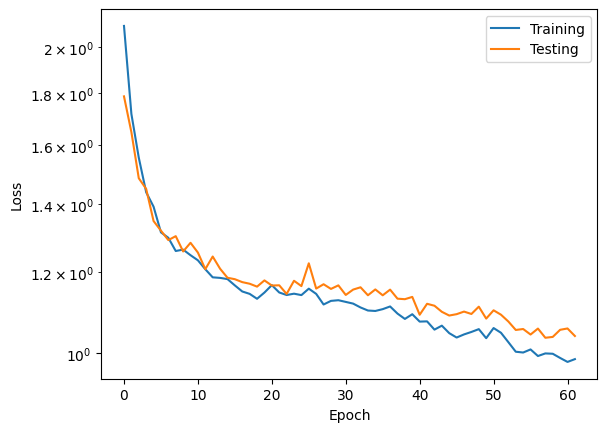

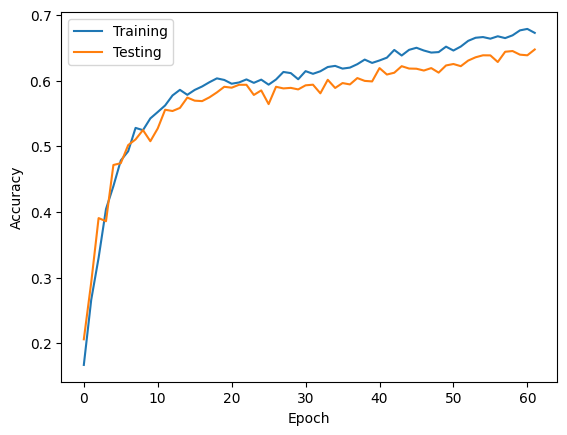

In [ ]:
stats.plot()

In [ ]:
net.save_to_npz('./network.npz')

In [ ]:
net2 = ExInbitoryNetwork(6,num_hidden_1, num_hidden_2, num_outputs, beta, grad, threshold=1.2).to(device)

/home/franzhd/miniconda3/envs/snn_torch/lib/python3.10/site-packages/brevitas/nn/mixin/base.py:77: UserWarning: Keyword arguments are being passed but they not being used.
  warn('Keyword arguments are being passed but they not being used.')


In [ ]:
net2.from_npz('./network.npz')

AttributeError: 'NoneType' object has no attribute 'to'

In [ ]:
net2.to(device)

ExInbitoryNetwork(
  (linear1): QuantLinear(
    in_features=6, out_features=128, bias=False
    (input_quant): ActQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
    )
    (output_quant): ActQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
    )
    (weight_quant): WeightQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
      (tensor_quant): RescalingIntQuant(
        (int_quant): IntQuant(
          (float_to_int_impl): RoundSte()
          (tensor_clamp_impl): TensorClampSte()
          (delay_wrapper): DelayWrapper(
            (delay_impl): _NoDelay()
          )
        )
        (scaling_impl): StatsFromParameterScaling(
          (parameter_list_stats): _ParameterListStats(
            (first_tracked_param): _ViewParameterWrapper(
              (view_shape_impl): OverTensorView()
            )
            (extra_tracked_params_list): ModuleList(
              (0-3): 4 x _ViewCatParameterWrapper(
                (view_s

In [ ]:
assistant2 = Assistant(net2, loss_fn, optimizer, stats, classifier=True, scheduler=scheduler)

In [ ]:
count = 0
for epoch in range(num_epochs):
        labels = []
        outputs = []
        # if epoch % 20 == 0:
        #     assistant.reduce_lr()
        if count < 10:
            count = count+1
            tqdm_dataloader = tqdm(train_loader)
            for _, batch in enumerate(tqdm_dataloader): # training loop
                input, label = batch
                
                output = assistant2.train(input, label)
                tqdm_dataloader.set_description(f'\r[Epoch {epoch:2d}/{num_epochs}] Training: {stats.training}')

            tqdm_dataloader = tqdm(test_loader)
            for _, batch in enumerate(tqdm_dataloader): #eval loop
                input, label = batch
                output = assistant2.test(input, label)
                tqdm_dataloader.set_description(f'\r[Epoch {epoch:2d}/{num_epochs}] Validation: {stats.testing}')
            
                if len(outputs) == 0:
                    outputs = output.to('cpu').detach()
                    labels = label.to('cpu').detach()
                else:
                    outputs = torch.cat((outputs, output.to('cpu').detach()), dim=1)
                    labels = torch.cat((labels, label.to('cpu').detach()))


            stats.update()

            if stats.testing.best_accuracy:
                count = 0
                _, predictions = outputs.sum(dim=0).max(1)
                gen_confusion_matrix(predictions,labels, './')
                #torch.save(net.state_dict(), '/network.pt')
                stats.save('./')

            del outputs
            del labels

[Epoch  0/200] Training: loss =     0.98162 (min =     0.97986)     accuracy = 0.67669 (max = 0.67868) : 100%|██████████| 43/43 [00:17<00:00,  2.39it/s]
[Epoch  0/200] Validation: loss =     1.06654 (min =     1.03498)     accuracy = 0.63992 (max = 0.64738) : 100%|██████████| 15/15 [00:03<00:00,  4.40it/s]
[Epoch  1/200] Training: loss =     0.98533 (min =     0.97986)     accuracy = 0.67592 (max = 0.67868) : 100%|██████████| 43/43 [00:17<00:00,  2.45it/s]
[Epoch  1/200] Validation: loss =     1.06654 (min =     1.03498)     accuracy = 0.63992 (max = 0.64738) : 100%|██████████| 15/15 [00:03<00:00,  4.43it/s]
[Epoch  2/200] Training: loss =     0.98533 (min =     0.97986)     accuracy = 0.67592 (max = 0.67868) : 100%|██████████| 43/43 [00:17<00:00,  2.43it/s]
[Epoch  2/200] Validation: loss =     1.06654 (min =     1.03498)     accuracy = 0.63992 (max = 0.64738) : 100%|██████████| 15/15 [00:03<00:00,  4.41it/s]
[Epoch  3/200] Training: loss =     0.98533 (min =     0.97986)     accuracy